In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [82]:
df_azure = pd.read_csv("azure.csv")
print(df_azure.columns)
df_azure.shape

Index(['timestamp', 'min cpu', 'max cpu', 'avg cpu'], dtype='object')


(8640, 4)

In [83]:
df_azure.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8640 entries, 0 to 8639
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  8640 non-null   object 
 1   min cpu    8640 non-null   float64
 2   max cpu    8640 non-null   float64
 3   avg cpu    8640 non-null   float64
dtypes: float64(3), object(1)
memory usage: 270.1+ KB


In [84]:
df_azure['timestamp'] = pd.to_datetime(df_azure['timestamp'], errors='coerce')


In [85]:
df_azure['hour'] = df_azure['timestamp'].apply(lambda x: x.hour)

In [86]:
df_azure.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8640 entries, 0 to 8639
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  8640 non-null   datetime64[ns]
 1   min cpu    8640 non-null   float64       
 2   max cpu    8640 non-null   float64       
 3   avg cpu    8640 non-null   float64       
 4   hour       8640 non-null   int64         
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 337.6 KB


In [87]:
def draw_line_plot(df, timestamp_column, feature_column, plot_size=(10, 6)):
    # Set the size of the plot
    plt.figure(figsize=plot_size)
    
    # Plot the data with timestamp on the x-axis and the feature on the y-axis
    plt.plot(df[timestamp_column], df[feature_column], linestyle='-')
    
    # Add title and labels
    plt.title(f'Line Plot of {feature_column} over Time')
    plt.xlabel('Time')
    plt.ylabel(feature_column)
    
    # Optionally, rotate the x-axis labels for better readability
    plt.xticks(rotation=45)
    
    # Ensure a tight layout so everything fits without overlap
    plt.tight_layout()
    
    # Show the plot
    plt.show()


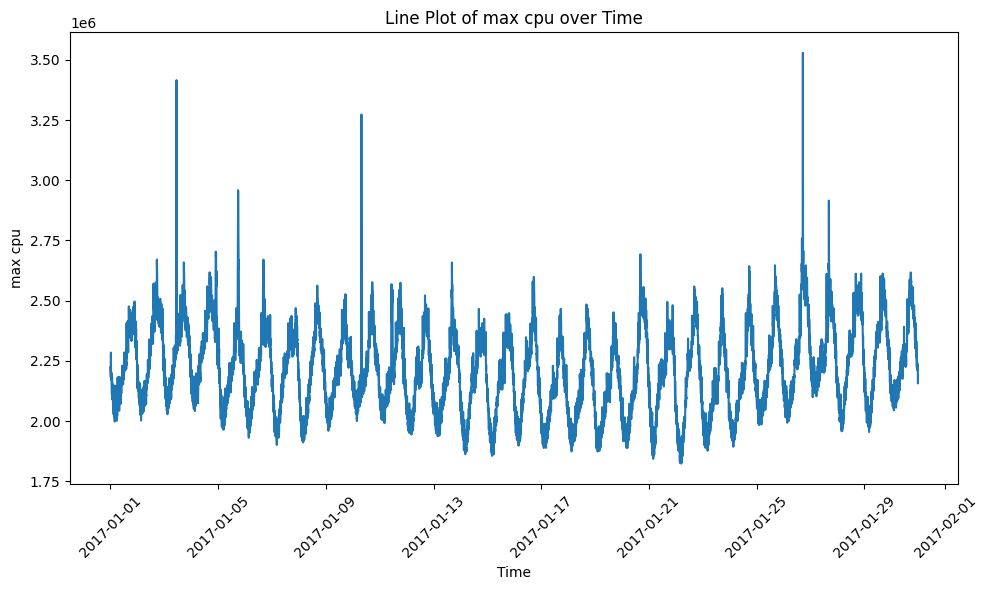

In [88]:
draw_line_plot(df_azure,"timestamp","max cpu")

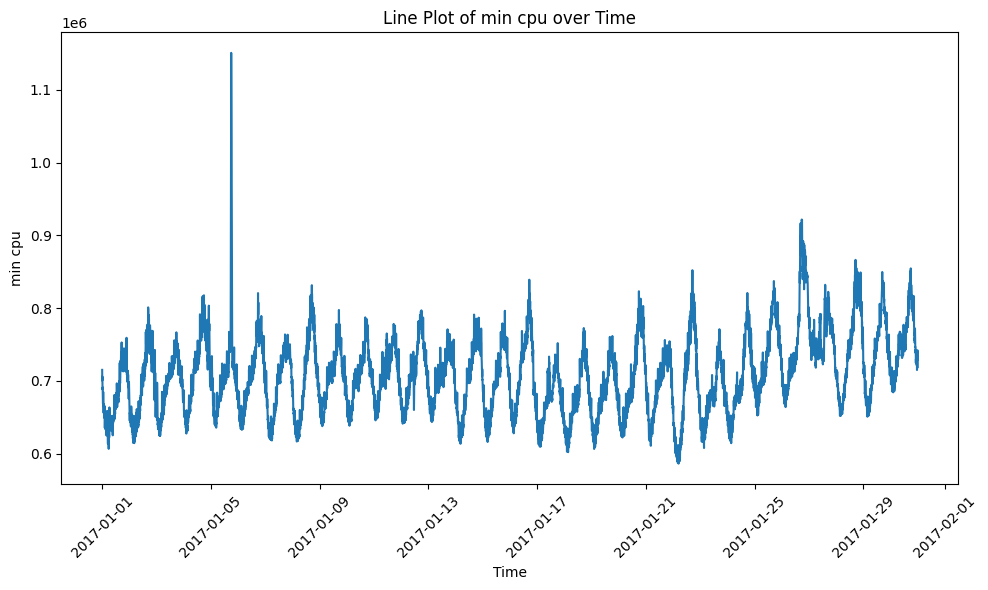

In [89]:
draw_line_plot(df_azure,"timestamp","min cpu")

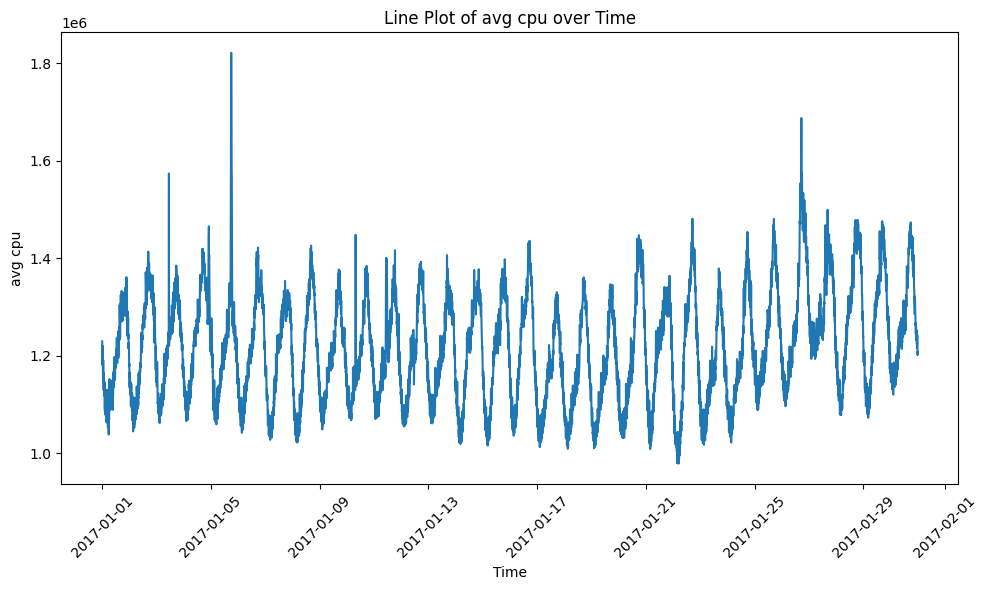

In [90]:
draw_line_plot(df_azure,"timestamp","avg cpu")

In [91]:
df_azure.isnull().sum()

timestamp    0
min cpu      0
max cpu      0
avg cpu      0
hour         0
dtype: int64

In [92]:
def hour_group(df,agg):
    state_app = df.groupby('hour').agg({'avg cpu': agg}).reset_index()  # group by
    state_app.sort_values(by=['avg cpu'],inplace=True, ascending=False) # sorting in descending order

    plt.figure(figsize=(15, 5))
    x_state = list(state_app['hour'].values) # defining x axis
    y_state = list(state_app['avg cpu'].values) # defining y axis
    plt.bar(x_state,y_state,width = 0.4)
    plt.title(f'Aggregate {agg} of avg cpu over hour')
    plt.show()

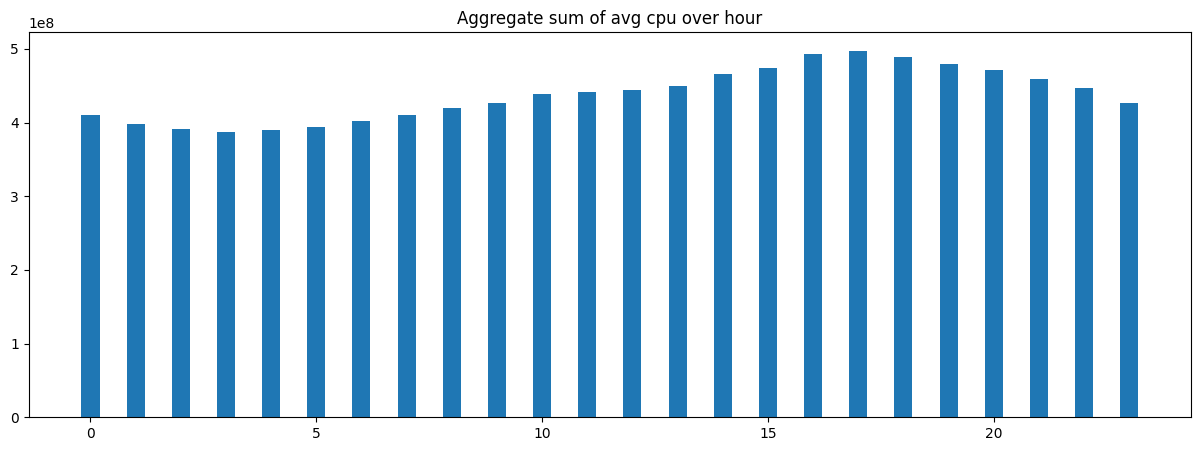

In [93]:
hour_group(df_azure,'sum')

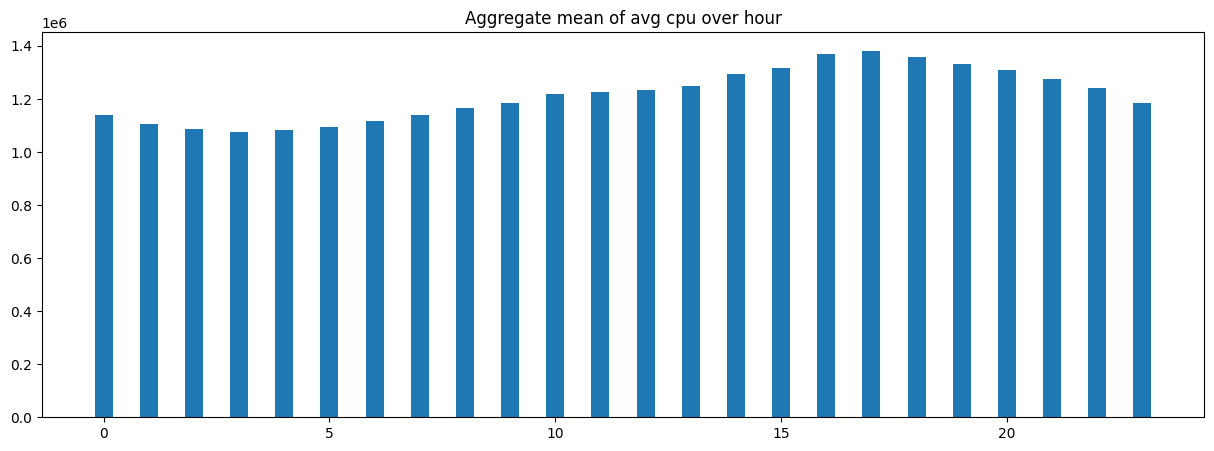

In [94]:
hour_group(df_azure,'mean')

# Arima Model

In [95]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Prepare Data

In [96]:
df = df_azure.copy()
df = df[["timestamp","avg cpu"]]
df.set_index('timestamp', inplace=True)

<Axes: title={'center': 'Average CPU Usage Over Time'}, xlabel='timestamp'>

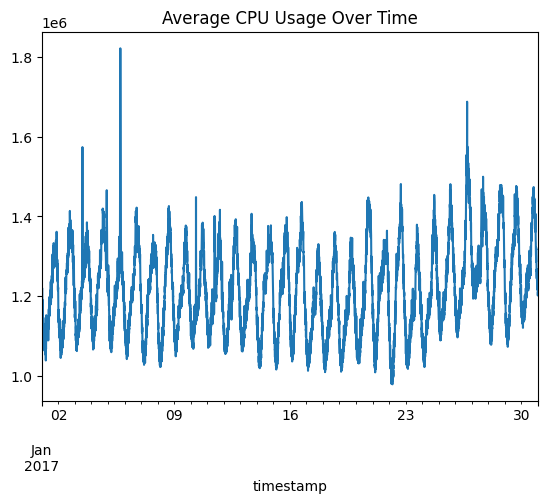

In [97]:
df['avg cpu'].plot(title='Average CPU Usage Over Time')

# Split Data

In [98]:
# Define a point to split the data (e.g., 80% train, 20% test)
split_point = int(len(df) * 0.8)
train, test = df.iloc[:split_point], df.iloc[split_point:]

# Display sizes of the datasets
print(f"Training data size: {len(train)}")
print(f"Testing data size: {len(test)}")

Training data size: 6912
Testing data size: 1728


# Check if data is stationary or not

In [99]:

result = adfuller(train['avg cpu'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Data is stationary since p value not greater than 0.05

ADF Statistic: -9.260116951438105
p-value: 1.4145410931808e-15


# Determine p,d,q

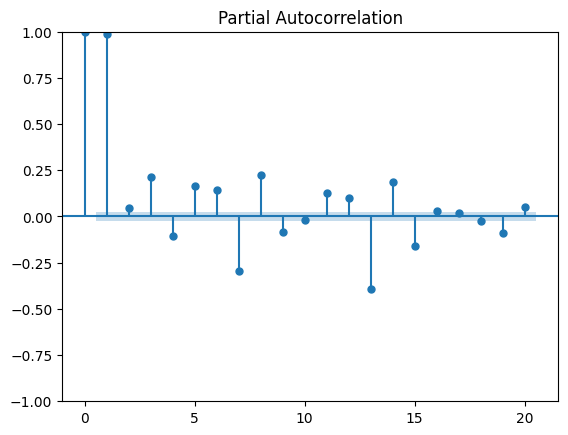

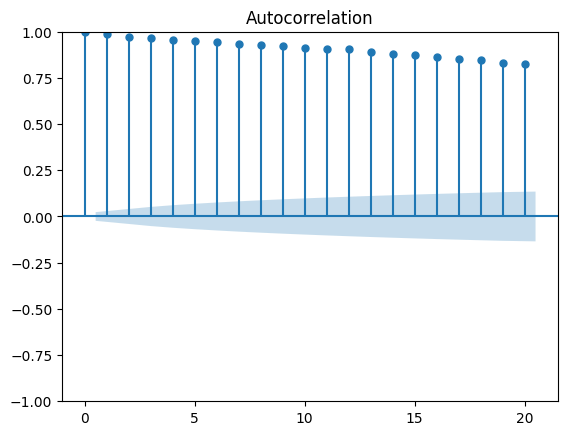

In [100]:
plot_pacf(train['avg cpu'], lags=20)  # Helps to determine 'p'
plt.show()

plot_acf(train['avg cpu'], lags=20)   # Helps to determine 'q'
plt.show()

# Using Grid Search

In [102]:
def evaluate_arima_model(train_data, order):
    # Fit ARIMA model
    model = ARIMA(train_data, order=order)
    model_fit = model.fit()
    return model_fit.aic

def arima_grid_search(train, p_values, d_values, q_values):
    train = train.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    aic = evaluate_arima_model(train, order)
                    if aic < best_score:
                        best_score, best_cfg = aic, order
                    print(f'ARIMA{order} AIC={aic:.3f}')
                except:
                    continue
    ##print(f'Best ARIMA{best_cfg} AIC={best_score:.3f}')
    return best_cfg

In [103]:
p_values = range(0, 4)
d_values = range(0, 3)
q_values = range(0, 4)

best_order = arima_grid_search(train['avg cpu'], p_values, d_values, q_values)


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecno

ARIMA(0, 0, 0) AIC=233499.343
ARIMA(0, 0, 1) AIC=174495.696


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


ARIMA(0, 0, 2) AIC=173055.125


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


ARIMA(0, 0, 3) AIC=172776.319
ARIMA(0, 1, 0) AIC=154995.507


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecno

ARIMA(0, 1, 1) AIC=154976.472


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


ARIMA(0, 1, 2) AIC=154756.584


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


ARIMA(0, 1, 3) AIC=154749.918
ARIMA(0, 2, 0) AIC=160109.615


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecno

ARIMA(0, 2, 1) AIC=156454.452


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


ARIMA(0, 2, 2) AIC=156006.374


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


ARIMA(0, 2, 3) AIC=155784.975
ARIMA(1, 0, 0) AIC=154972.821


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecno

ARIMA(1, 0, 1) AIC=154951.553


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


ARIMA(1, 0, 2) AIC=154603.247


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


ARIMA(1, 0, 3) AIC=154601.077
ARIMA(1, 1, 0) AIC=154981.907


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecno

ARIMA(1, 1, 1) AIC=154883.189


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


ARIMA(1, 1, 2) AIC=154748.220


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


ARIMA(1, 1, 3) AIC=154146.515


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


ARIMA(1, 2, 0) AIC=159112.305


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


ARIMA(1, 2, 1) AIC=156119.235


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


ARIMA(1, 2, 2) AIC=155864.177


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\rajpo\Pych

ARIMA(1, 2, 3) AIC=155369.425
ARIMA(2, 0, 0) AIC=154961.249


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


ARIMA(2, 0, 1) AIC=154933.799


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


ARIMA(2, 0, 2) AIC=154602.854


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


ARIMA(2, 0, 3) AIC=153501.177


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


ARIMA(2, 1, 0) AIC=154778.222


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


ARIMA(2, 1, 1) AIC=154733.185


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\rajpo\Pych

ARIMA(2, 1, 2) AIC=153394.159


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


ARIMA(2, 1, 3) AIC=153316.205
ARIMA(2, 2, 0) AIC=157520.865


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


ARIMA(2, 2, 1) AIC=155863.490


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


ARIMA(2, 2, 2) AIC=155777.508


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


ARIMA(2, 2, 3) AIC=155020.730


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


ARIMA(3, 0, 0) AIC=154638.168


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


ARIMA(3, 0, 1) AIC=154549.206


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


ARIMA(3, 0, 2) AIC=153090.249


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


ARIMA(3, 0, 3) AIC=152977.827


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


ARIMA(3, 1, 0) AIC=154746.340


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


ARIMA(3, 1, 1) AIC=154727.517


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\rajpo\Pych

ARIMA(3, 1, 2) AIC=153394.321


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


ARIMA(3, 1, 3) AIC=153340.892
ARIMA(3, 2, 0) AIC=157319.759


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


ARIMA(3, 2, 1) AIC=155839.976


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


ARIMA(3, 2, 2) AIC=155252.019


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


ARIMA(3, 2, 3) AIC=154288.319


c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [104]:
best_order

(3, 0, 3)

# Fit model with best (p,d,q)

In [105]:
best_model = ARIMA(train['avg cpu'], order=best_order)
best_model_fit = best_model.fit()

# Forecast on test data
forecasts = best_model_fit.forecast(steps=len(test))

# In-sample predictions
in_sample_preds = best_model_fit.predict(start=train.index[0], end=train.index[-1])

c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\rajpo\PycharmProjects\Tecnokrat\Cloud usage\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


# Evaluate on both train and test set

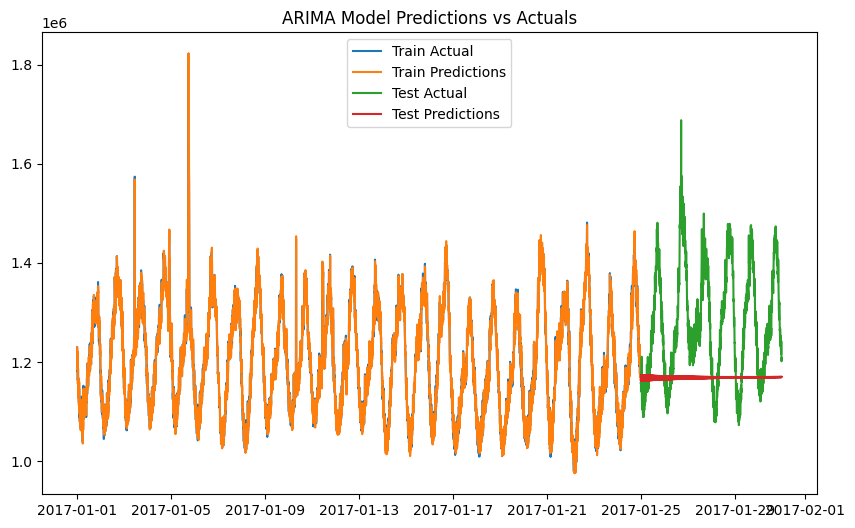

Train Mean Squared Error: 234347296.41
Train Root Mean Squared Error: 15308.41
Test Mean Squared Error: 23915411501.90
Test Root Mean Squared Error: 154646.08


In [106]:
# Calculate metrics
train_mse = mean_squared_error(train['avg cpu'], in_sample_preds)
test_mse = mean_squared_error(test['avg cpu'], forecasts)

train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

# Plotting results
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['avg cpu'], label='Train Actual')
plt.plot(train.index, in_sample_preds, label='Train Predictions')
plt.plot(test.index, test['avg cpu'], label='Test Actual')
plt.plot(test.index, forecasts, label='Test Predictions')
plt.title('ARIMA Model Predictions vs Actuals')
plt.legend()
plt.show()

print(f'Train Mean Squared Error: {train_mse:.2f}')
print(f'Train Root Mean Squared Error: {train_rmse:.2f}')
print(f'Test Mean Squared Error: {test_mse:.2f}')
print(f'Test Root Mean Squared Error: {test_rmse:.2f}')


# Try Ensemble Models

In [108]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [ ]:
X_train = train.drop('avg cpu', axis=1)
y_train = train['avg cpu']
X_test = test.drop('avg cpu', axis=1)
y_test = test['avg cpu']

In [109]:
# Splitting features and target
train_ = train.copy()
test_ = test.copy()

train_ = train_.reset_index()
test_ = test_.reset_index()

X_train = train_.drop('avg cpu', axis=1)
y_train = train_['avg cpu']
X_test = test_.drop('avg cpu', axis=1)
y_test = test_['avg cpu']
X_train = X_train.reset_index()
X_test = X_test.reset_index()

In [110]:
X_train.drop(['index'],axis=1,inplace=True)
X_test.drop(['index'],axis=1,inplace=True)

In [111]:
X_train1 = X_train.copy()
X_test1 = X_test.copy()

In [112]:
def feature_extraction(df):
    df['year'] = df['timestamp'].dt.year
    df['month'] = df['timestamp'].dt.month
    df['day'] = df['timestamp'].dt.day
    df['hour'] = df['timestamp'].dt.hour
    df['weekday'] = df['timestamp'].dt.weekday

    # Optional: Cyclical encoding for hour and weekday
    df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)
    df['weekday_sin'] = np.sin(2 * np.pi * df['weekday']/7)
    df['weekday_cos'] = np.cos(2 * np.pi * df['weekday']/7)

    # Drop the original timestamp column if it is no longer needed
    df.drop('timestamp', axis=1, inplace=True)
    return df

In [113]:
X_train1 = feature_extraction(X_train1)
X_test1 = feature_extraction(X_test1)

In [114]:
X_train1

,year,month,day,hour,weekday,hour_sin,hour_cos,weekday_sin,weekday_cos
0,2017,1,1,0,6,0.000000,1.000000,-0.781831,0.62349
1,2017,1,1,0,6,0.000000,1.000000,-0.781831,0.62349
2,2017,1,1,0,6,0.000000,1.000000,-0.781831,0.62349
3,2017,1,1,0,6,0.000000,1.000000,-0.781831,0.62349
4,2017,1,1,0,6,0.000000,1.000000,-0.781831,0.62349
...,...,...,...,...,...,...,...,...,...
6907,2017,1,24,23,1,-0.258819,0.965926,0.781831,0.62349
6908,2017,1,24,23,1,-0.258819,0.965926,0.781831,0.62349
6909,2017,1,24,23,1,-0.258819,0.965926,0.781831,0.62349
6910,2017,1,24,23,1,-0.258819,0.965926,0.781831,0.62349


In [115]:
X_train1.shape,y_train.shape

((6912, 9), (6912,))

In [116]:
X_test1.shape,y_test.shape

((1728, 9), (1728,))

In [117]:
def calculate_rmse(true_values, predictions):
    mse = mean_squared_error(true_values, predictions)
    rmse = np.sqrt(mse)
    return mse, rmse

# Random Forest

In [118]:
y_train.mean(),y_test.mean()

(1200543.0248180393, 1276133.4170093809)

In [119]:
# Initialize and train the Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)  # You can adjust these parameters
rf.fit(X_train1, y_train)

# Make predictions
rf_train_pred = rf.predict(X_train1)
rf_test_pred = rf.predict(X_test1)

rf_train_mse, rf_train_rmse = calculate_rmse(y_train, rf_train_pred)
rf_test_mse, rf_test_rmse = calculate_rmse(y_test, rf_test_pred)

print(f'Random Forest Train MSE: {rf_train_mse}, Train RMSE: {rf_train_rmse}')
print(f'Random Forest Test MSE: {rf_test_mse}, Test RMSE: {rf_test_rmse}')

Random Forest Train MSE: 465130319.01693076, Train RMSE: 21566.880141015547
Random Forest Test MSE: 8242016889.716073, Test RMSE: 90785.5544110189


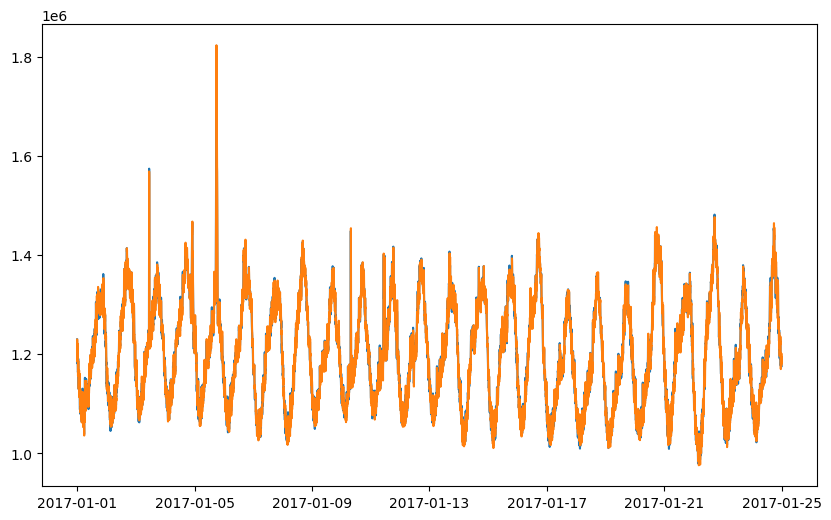

In [120]:
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['avg cpu'], label='Train Actual')
plt.plot(train.index, in_sample_preds, label='Train Predictions')

plt.plot(train.index, test['avg cpu'], label='Test Actual')
plt.plot(train.index, in_sample_preds, label='Train Predictions')

# Xgboost

In [121]:
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train1, y_train)
xgb_train_pred = xgb.predict(X_train1)
xgb_test_pred = xgb.predict(X_test1)
xgb_train_mse, xgb_train_rmse = calculate_rmse(y_train, xgb_train_pred)
xgb_test_mse, xgb_test_rmse = calculate_rmse(y_test, xgb_test_pred)
print(f'XGBoost Train MSE: {xgb_train_mse}, Train RMSE: {xgb_train_rmse}')
print(f'XGBoost Test MSE: {xgb_test_mse}, Test RMSE: {xgb_test_rmse}')

XGBoost Train MSE: 484551316.4795545, Train RMSE: 22012.52635386394
XGBoost Test MSE: 7613539141.92118, Test RMSE: 87255.59662234383


# LGBM

In [122]:
lgbm = LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

lgbm.fit(X_train1, y_train)

lgbm_train_pred = lgbm.predict(X_train1)
lgbm_test_pred = lgbm.predict(X_test1)

lgbm_train_mse, lgbm_train_rmse = calculate_rmse(y_train, lgbm_train_pred)
lgbm_test_mse, lgbm_test_rmse = calculate_rmse(y_test, lgbm_test_pred)

print(f'LightGBM Train MSE: {lgbm_train_mse}, Train RMSE: {lgbm_train_rmse}')
print(f'LightGBM Test MSE: {lgbm_test_mse}, Test RMSE: {lgbm_test_rmse}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 109
[LightGBM] [Info] Number of data points in the train set: 6912, number of used features: 7
[LightGBM] [Info] Start training from score 1200543.024993
LightGBM Train MSE: 499438566.7178253, Train RMSE: 22348.122219055123
LightGBM Test MSE: 7710376930.363299, Test RMSE: 87808.75201461013


# LSTM (Having Timestamp set as index)

In [53]:
df_azure = pd.read_csv("azure.csv")
print(df_azure.columns)
df_azure.shape

Index(['timestamp', 'min cpu', 'max cpu', 'avg cpu'], dtype='object')


(8640, 4)

In [54]:
df = df_azure.copy()
df = df[["timestamp","avg cpu"]]
df.set_index('timestamp', inplace=True)

In [55]:
df.head()

,avg cpu
timestamp,
2017-01-01 00:00:00,1.229569e+06
2017-01-01 00:05:00,1.211322e+06
2017-01-01 00:10:00,1.206635e+06
2017-01-01 00:15:00,1.190369e+06
2017-01-01 00:20:00,1.180992e+06


# Slpit Dataset

In [56]:
data = df.filter(['avg cpu'])
dataset = data.values

# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .80 ))

training_data_len

6912

In [57]:
train_data = data.iloc[0:int(training_data_len), :]
test_data = data.iloc[training_data_len - 60: , :]

train_data.shape,test_data.shape

((6912, 1), (1788, 1))

# Normalizing the data

In [58]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaled_train_data = scaler.fit_transform(train_data.filter(['avg cpu']).values) 
scaled_test_data = scaler.transform(test_data.filter(['avg cpu']).values)

In [59]:
scaled_train_data.shape,scaled_test_data.shape

((6912, 1), (1788, 1))

# Reshape Data to feed LSTM model

In [60]:
def create_lstm_sequence(data,seq_length=12):
    x_ = []
    y_ = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        x_.append(x)
        y_.append(y)
    return np.array(x_), np.array(y_)
    

In [61]:
X_train, y_train = create_lstm_sequence(scaled_train_data)
X_test, y_test = create_lstm_sequence(scaled_test_data)

In [62]:
X_train.shape,y_train.shape

((6899, 12, 1), (6899, 1))

In [63]:
X_test.shape,y_test.shape


((1775, 12, 1), (1775, 1))

In [64]:
scaled_train_data[:13]

array([[0.29762311],
       [0.27598004],
       [0.27042116],
       [0.25112801],
       [0.24000641],
       [0.28661585],
       [0.25366547],
       [0.22031577],
       [0.21897754],
       [0.22023758],
       [0.22274266],
       [0.2513936 ],
       [0.22844245]])

In [65]:
X_train[0],y_train[0]

(array([[0.29762311],
        [0.27598004],
        [0.27042116],
        [0.25112801],
        [0.24000641],
        [0.28661585],
        [0.25366547],
        [0.22031577],
        [0.21897754],
        [0.22023758],
        [0.22274266],
        [0.2513936 ]]),
 array([0.22844245]))

# Building LSTM Model

In [66]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [67]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (X_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


In [78]:
X_train[0],(y_train[0])

(array([[0.29762311],
        [0.27598004],
        [0.27042116],
        [0.25112801],
        [0.24000641],
        [0.28661585],
        [0.25366547],
        [0.22031577],
        [0.21897754],
        [0.22023758],
        [0.22274266],
        [0.2513936 ]]),
 array([1171241.89756101]))

In [76]:
X_test[0],y_test[0]

(array([[0.41748757],
        [0.39639547],
        [0.4289235 ],
        [0.47080224],
        [0.4702854 ],
        [0.46091948],
        [0.42102914],
        [0.41870449],
        [0.44440253],
        [0.42039682],
        [0.39944887],
        [0.40144698]]),
 array([1303697.63362699]))

In [68]:
history = model.fit(X_train, y_train, batch_size=32, epochs=5,verbose=1,validation_data=(X_test,y_test))
history

Epoch 1/5
216/216 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0073 - val_loss: 9.1241e-04
Epoch 2/5
216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0012 - val_loss: 7.7879e-04
Epoch 3/5
216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 8.7090e-04 - val_loss: 6.4161e-04
Epoch 4/5
216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 7.9453e-04 - val_loss: 5.7313e-04
Epoch 5/5
216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.5475e-04 - val_loss: 5.3776e-04


# Epoch vs Loss

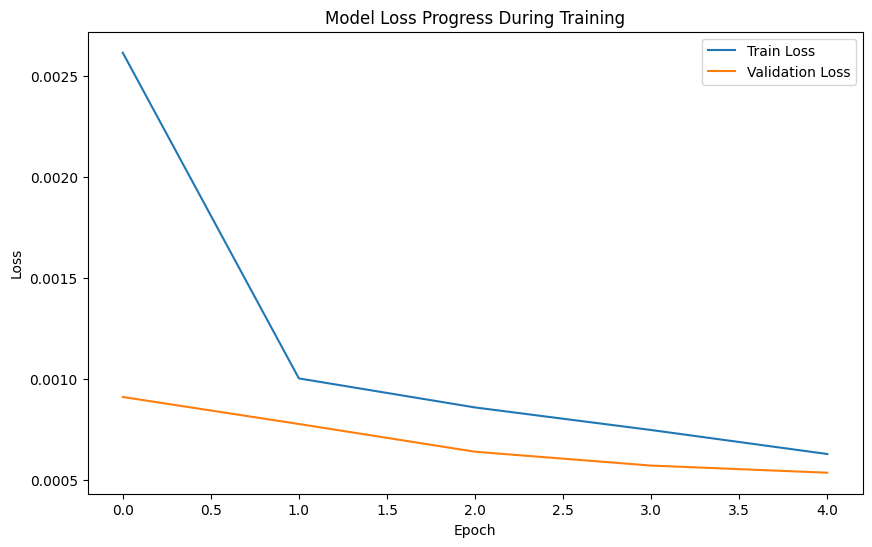

In [69]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Progress During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


In [70]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Predicting and inverse transform to original scale
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)
y_train = scaler.inverse_transform(y_train.reshape(-1,1))
y_test = scaler.inverse_transform(y_test.reshape(-1,1))

# Calculate performance metrics
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mape = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100

test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

print('Train MSE:', train_mse)
print('Train RMSE:', train_rmse)
print('Train MAE:', train_mae)
print('Train MAPE:', train_mape)

print('Test MSE:', test_mse)
print('Test RMSE:', test_rmse)
print('Test MAE:', test_mae)
print('Test MAPE:', test_mape)


216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Train MSE: 407925373.9288545
Train RMSE: 20197.162521722068
Train MAE: 14781.702077667618
Train MAPE: 1.2285960056716367
Test MSE: 382266928.78016216
Test RMSE: 19551.647725451738
Test MAE: 15306.622074229499
Test MAPE: 1.197840704502406


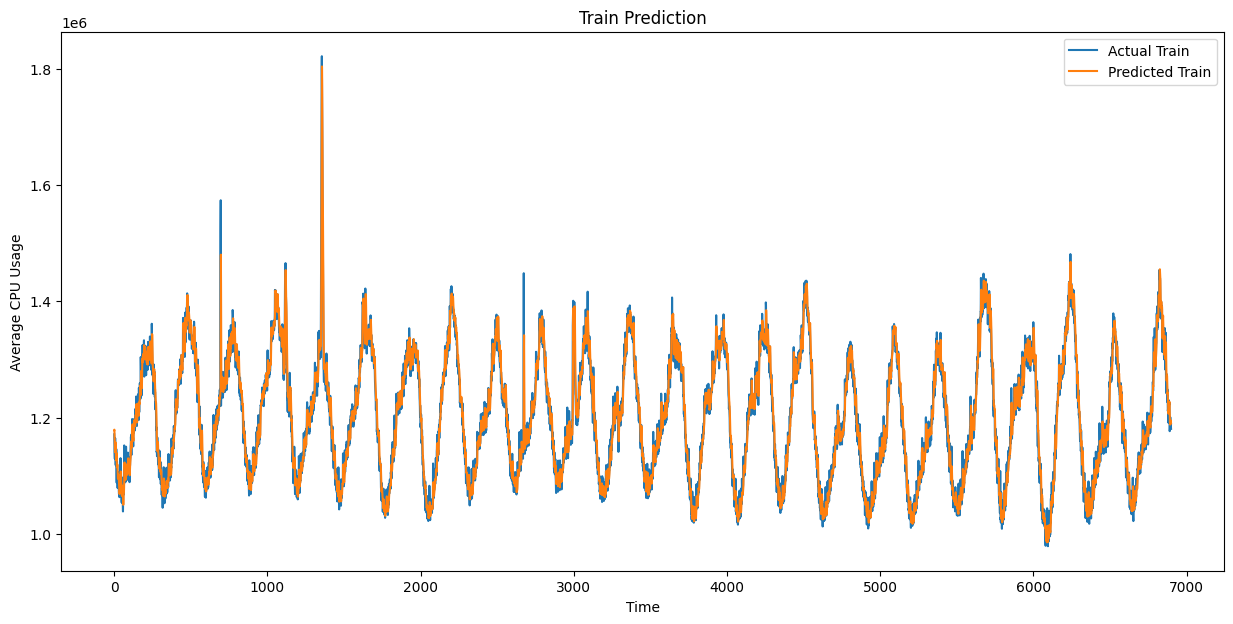

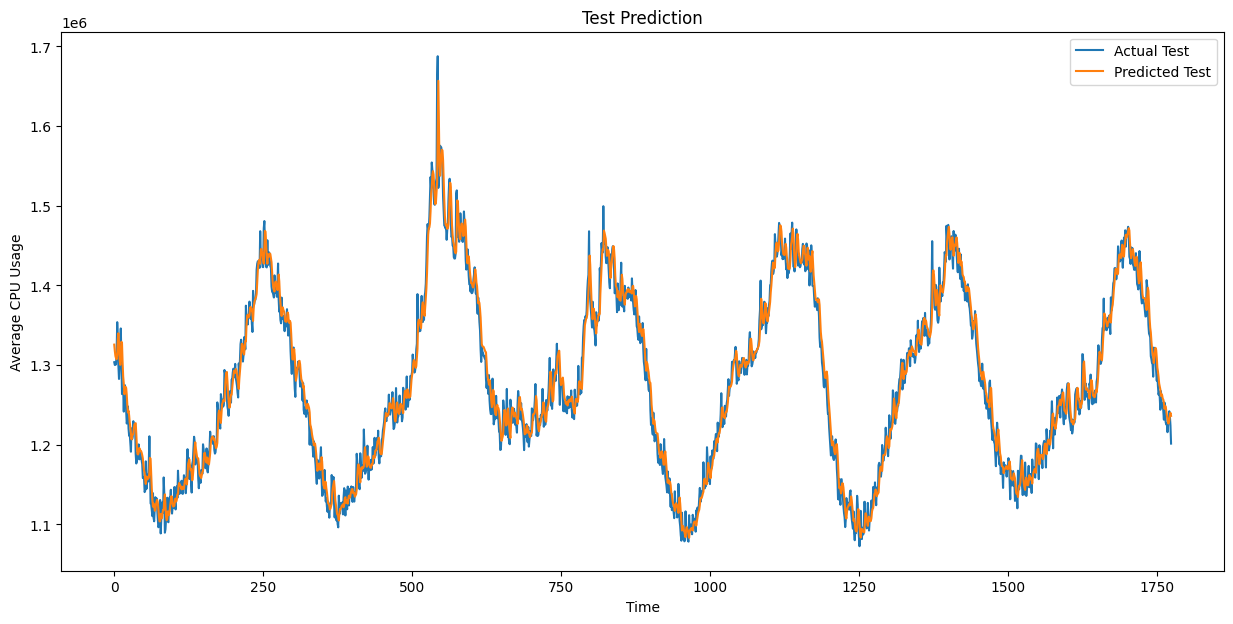

In [71]:
import matplotlib.pyplot as plt

# Plot training data
plt.figure(figsize=(15,7))
plt.plot(y_train, label='Actual Train')
plt.plot(y_train_pred, label='Predicted Train')
plt.title('Train Prediction')
plt.xlabel('Time')
plt.ylabel('Average CPU Usage')
plt.legend()
plt.show()

# Plot testing data
plt.figure(figsize=(15,7))
plt.plot(y_test, label='Actual Test')
plt.plot(y_test_pred, label='Predicted Test')
plt.title('Test Prediction')
plt.xlabel('Time')
plt.ylabel('Average CPU Usage')
plt.legend()
plt.show()

# LSTM (with Timestamp as not set as index)

In [46]:
def create_sequences_lstm_2(data, seq_length=12):
    xs = []
    ys = []
    indices = []
    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length), 0:1]  # Select only the feature columns
        y = data[i+seq_length, 0]  # Select the target value
        xs.append(x)
        ys.append(y)
        indices.append(data[i+seq_length, 1])  # Capture the timestamp for plotting
    return np.array(xs), np.array(ys), np.array(indices)

In [36]:
df.reset_index(inplace=True)
df

,timestamp,avg cpu
0,2017-01-01 00:00:00,1.229569e+06
1,2017-01-01 00:05:00,1.211322e+06
2,2017-01-01 00:10:00,1.206635e+06
3,2017-01-01 00:15:00,1.190369e+06
4,2017-01-01 00:20:00,1.180992e+06
...,...,...
8635,2017-01-30 23:35:00,1.242129e+06
8636,2017-01-30 23:40:00,1.235937e+06
8637,2017-01-30 23:45:00,1.224276e+06
8638,2017-01-30 23:50:00,1.201533e+06


In [39]:
train_data = df.iloc[0:int(training_data_len), :]
test_data = df.iloc[training_data_len - 60: , :]

In [40]:
train_data = train_data[['avg cpu', 'timestamp']].to_numpy()
test_data = test_data[['avg cpu', 'timestamp']].to_numpy()

In [41]:
train_data.shape,test_data.shape

((6912, 2), (1788, 2))

In [42]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_data[:, 0] = scaler.fit_transform(train_data[:, 0].reshape(-1, 1)).flatten()
test_data[:, 0] = scaler.transform(test_data[:, 0].reshape(-1, 1)).flatten()    

In [47]:
X_train, y_train,indices_train  = create_sequences_lstm_2(train_data)
X_test, y_test,indices_test = create_sequences_lstm_2(test_data)

In [49]:
train_indices = pd.to_datetime(indices_train)
test_indices = pd.to_datetime(indices_test)

In [50]:
X_train[0],y_train[0]

(array([[0.29762310546498805],
        [0.2759800410560376],
        [0.27042115919930554],
        [0.2511280089037595],
        [0.24000641455688387],
        [0.2866158535762102],
        [0.25366547015095864],
        [0.22031577354098641],
        [0.21897754141797],
        [0.22023757647777553],
        [0.22274266020493916],
        [0.25139359795288807]], dtype=object),
 0.2284424492892625)

In [51]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (X_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


In [52]:
history = model.fit(X_train, y_train, batch_size=32, epochs=5,verbose=1,validation_data=(X_test,y_test))
history

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

In [ ]:
# Plot training data
plt.figure(figsize=(15,7))
plt.plot(train_indices, y_train, label='Actual Train', color='blue')
plt.plot(train_indices, X_train[:, -1, 0], label='Predicted Train', color='orange')  # Assuming model predictions are stored similarly
plt.title('Train Prediction')
plt.xlabel('Time')
plt.ylabel('Average CPU Usage')
plt.legend()
plt.show()

# Plot testing data
plt.figure(figsize=(15,7))
plt.plot(test_indices, y_test, label='Actual Test', color='blue')
plt.plot(test_indices, X_test[:, -1, 0], label='Predicted Test', color='orange')  # Assuming model predictions are stored similarly
plt.title('Test Prediction')
plt.xlabel('Time')
plt.ylabel('Average CPU Usage')
plt.legend()
plt.show()